In [428]:
import sys
print(sys.version) # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [429]:
import tensorflow as tf

tf.enable_eager_execution()

In [430]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

from math import sqrt

from itertools import combinations, combinations_with_replacement

from cycler import cycler

In [431]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

df = pd.read_csv('/data/fp_ica.csv')
df = df.set_index('ID')

display(df[:10])
display(df.describe().T)

,Unnamed: 0,true_year,prediction,row,factor0,factor1,factor2,factor3,factor4,factor5,...,sido,sido_name,sido_cluster_code,sido_cluster,Area,norm_log_area,area_85,Entrance,Rooms,Baths
ID,,,,,,,,,,,,,,,,,,,,,
2829_105,0,0.520,0.564,0,0.611,1.785,-0.388,-0.324,0.403,-0.914,...,4100000000,경기도,1,경기,84.690,-0.010,True,복도식,3,2
999_37,1,0.360,0.407,1,-2.766,-0.138,-0.335,0.763,0.294,1.408,...,1100000000,서울시,0,서울,27.610,-3.228,False,복도식,1,1
7770_55A,2,0.200,0.392,2,-4.549,0.465,1.008,-0.274,-0.669,-0.723,...,2600000000,부산시,5,부산울산경남,41.520,-2.057,False,복도식,2,1
2140_92B,3,0.520,0.500,3,-0.829,1.609,0.456,-0.606,-0.178,0.384,...,4100000000,경기도,1,경기,67.430,-0.665,False,계단식,3,1
509_73,4,0.500,0.486,4,-0.539,1.325,-0.499,0.784,0.302,-0.240,...,1100000000,서울시,0,서울,52.470,-1.385,False,복도식,2,1
19478_113,5,0.740,0.750,5,-0.055,-0.499,0.356,-1.959,0.827,0.324,...,4200000000,강원도,3,강원,84.710,-0.010,True,계단식,3,2
8657_70,6,0.360,0.408,6,-3.012,0.229,-0.304,-0.009,0.197,0.447,...,4100000000,경기도,1,경기,53.190,-1.346,False,계단식,3,1
1856_61,7,0.400,0.461,7,-2.442,0.647,0.642,-0.463,0.314,0.458,...,4100000000,경기도,1,경기,45.900,-1.769,False,계단식,3,1
25606_107C,8,0.740,0.726,8,0.198,0.026,0.414,-0.265,1.089,-2.190,...,4100000000,경기도,1,경기,84.270,-0.025,True,계단식,3,2


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,50540.000,25269.500,14589.786,0.000,12634.750,25269.500,37904.250,50539.000
true_year,50540.000,0.701,0.169,0.000,0.580,0.720,0.820,1.000
prediction,50540.000,0.700,0.153,-1.194,0.581,0.731,0.818,0.976
row,50540.000,25269.500,14589.786,0.000,12634.750,25269.500,37904.250,50539.000
factor0,50540.000,-0.000,1.000,-5.706,-0.115,0.192,0.518,8.992
factor1,50540.000,0.000,1.000,-3.034,-0.794,-0.295,0.945,2.902
factor2,50540.000,0.000,1.000,-50.346,-0.175,0.079,0.335,2.597
factor3,50540.000,-0.000,1.000,-4.265,-0.427,0.113,0.588,3.586
factor4,50540.000,0.000,1.000,-6.852,-0.498,0.121,0.657,3.161
factor5,50540.000,0.000,1.000,-5.989,-0.597,0.014,0.575,5.242


In [432]:
col_factors = ['factor{}'.format(i) for i in range(7)]
col_attributes = ['year',
                  'N_Housings', 'N_Units',
                  'Max_Floors', 'Min_Floors',
                  'Area', 
                  'Rooms', 'Baths']

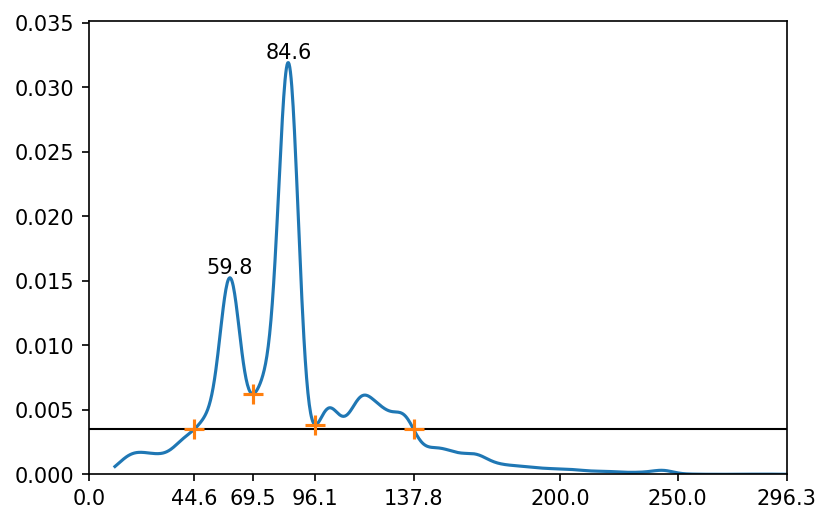

In [433]:
xlim = [df['Area'].min(), df['Area'].max()]
kernel = gaussian_kde(df['Area'])
xs = np.arange(*xlim, (xlim[1]-xlim[0])/1000)
ys = kernel(xs)
cuts, _ = find_peaks(-np.absolute(ys-np.average(ys)),
                      prominence=0.1*np.average(ys),
                      width=20)

peaks, _ = find_peaks(ys, height=2*np.average(ys))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.plot(xs, ys, c=colors[0])
ax.axhline(np.average(ys), c='k', lw=1)
ax.scatter(xs[cuts], ys[cuts], c=colors[1], s=100, marker='+', zorder=2.5)

[ax.text(x, y, '{:0.1f}'.format(x), ha='center', va='bottom') for x, y in zip(xs[peaks], ys[peaks])]

ax.set_xticks(np.append(xs[cuts], [0, 200, 250, xs.max()]))
ax.set_xlim(0, xs.max())
ax.set_ylim(0, ys.max()*1.10)
plt.show()

In [434]:
df['group_area'] = pd.cut(df['Area'], xs[cuts], labels=['60m2', '85m2', 'Above'])
df[col_attributes].groupby(df['group_area']).describe().T

group_area            60m2      85m2     Above
year       count 10970.000 20856.000 10971.000
           mean   2001.095  2004.913  2004.760
           std       8.984     8.030     7.712
           min    1969.000  1969.000  1971.000
           25%    1995.000  2000.000  2000.000
           50%    2000.000  2006.000  2006.000
           75%    2007.000  2011.000  2010.000
           max    2017.000  2019.000  2019.000
N_Housings count 10970.000 20856.000 10971.000
           mean    663.756   584.751   662.650
           std     654.323   562.917   610.596
           min       2.000     6.000    10.000
           25%     220.000   215.000   283.000
           50%     472.000   448.000   498.000
           75%     888.000   772.000   843.000
           max    6864.000  6864.000  6864.000
N_Units    count 10970.000 20856.000 10971.000
           mean    156.346   144.720    96.867
           std     198.015   173.418   104.470
           min       0.000     0.000     0.000
           25%      31.000    30.000    28.000
           50%      90.000    89.000    65.000
           75%     201.000   192.000   129.000
           max    2960.000  2938.000  1416.000
Max_Floors count 10970.000 20856.000 10971.000
           mean     17.373    18.917    21.033
           std       6.660     6.994     8.828
           min       3.000     3.000     3.000
           25%      15.000    15.000    15.000
           50%      17.000    18.000    20.000
...                    ...       ...       ...
Min_Floors std       5.248     5.711     7.044
           min       1.000     1.000     1.000
           25%       8.000     9.000    10.000
           50%      12.000    12.000    13.000
           75%      15.000    15.000    16.000
           max      55.000    60.000    61.000
Area       count 10970.000 20856.000 10971.000
           mean     58.438    83.053   117.104
           std       5.019     4.361    11.671
           min      44.650    69.500    96.070
           25%      58.172    84.110   106.630
           50%      59.840    84.850   116.810
           75%      59.970    84.960   126.665
           max      69.490    96.040   137.760
Rooms      count 10970.000 20856.000 10971.000
           mean      2.704     3.008     3.728
           std       0.506     0.190     0.479
           min       1.000     1.000     1.000
           25%       2.000     3.000     3.000
           50%       3.000     3.000     4.000
           75%       3.000     3.000     4.000
           max       5.000     5.000     6.000
Baths      count 10970.000 20856.000 10971.000
           mean      1.333     1.912     1.994
           std       0.472     0.286     0.148
           min       1.000     1.000     1.000
           25%       1.000     2.000     2.000
           50%       1.000     2.000     2.000
           75%       2.000     2.000     2.000
           max       3.000     3.000     4.000

[64 rows x 3 columns]

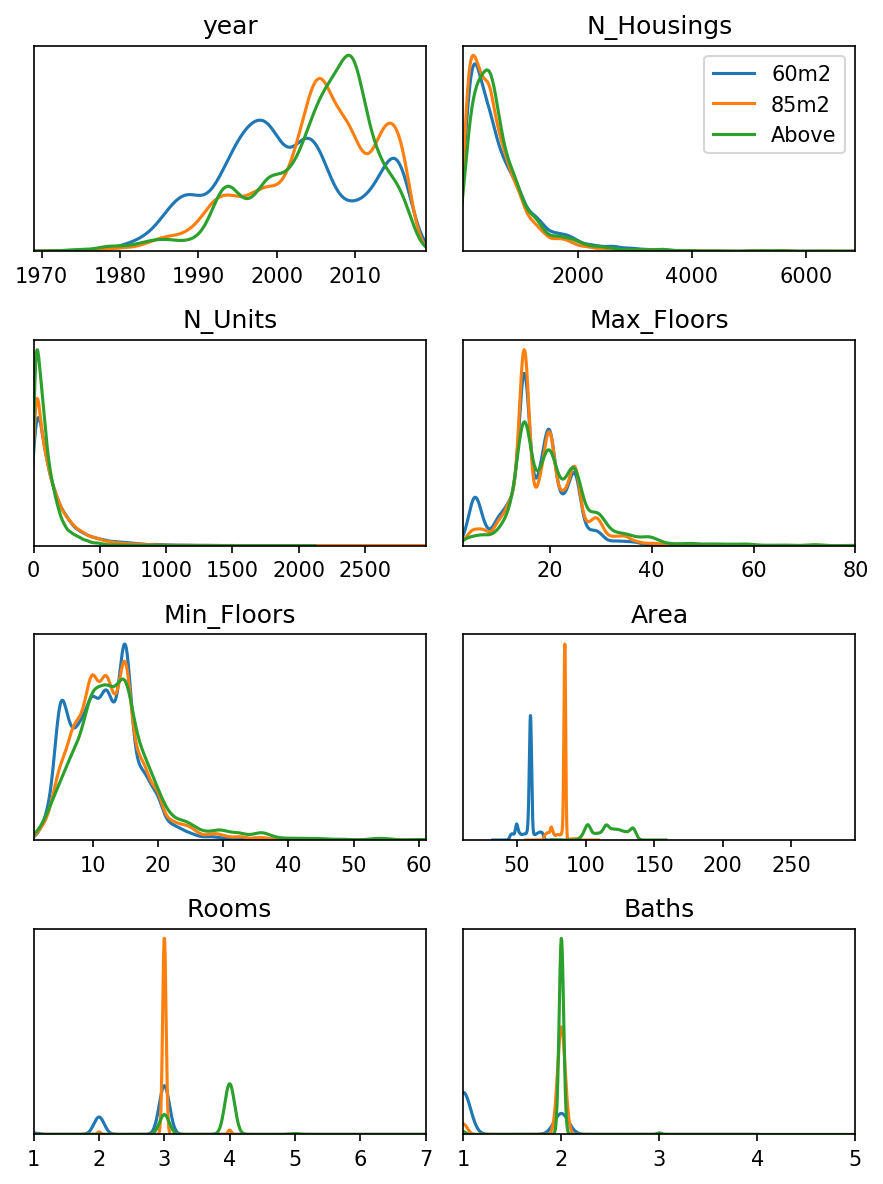

In [435]:
n_cols = 2
if len(col_attributes) % cols:
    n_rows = len(col_attributes)//n_cols + 1
else:
    n_rows = len(col_attributes)//n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 8), dpi=150)
axes = axes.flatten()
[axes[i].set_axis_off() for i in range(len(col_attributes), len(axes))]
    
for i, attr in enumerate(col_attributes):
    (df[attr]
     .groupby(df['group_area'])
     .plot.kde(xlim=(df[attr].min(), df[attr].max()),
               ax=axes[i]))
        
    axes[i].set_title(attr)
    axes[i].set_ylim(bottom=0)

[axes[i].yaxis.set_visible(False) for i in range(len(axes))]

axes[n_cols-1].legend()
# plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.tight_layout()
plt.show()

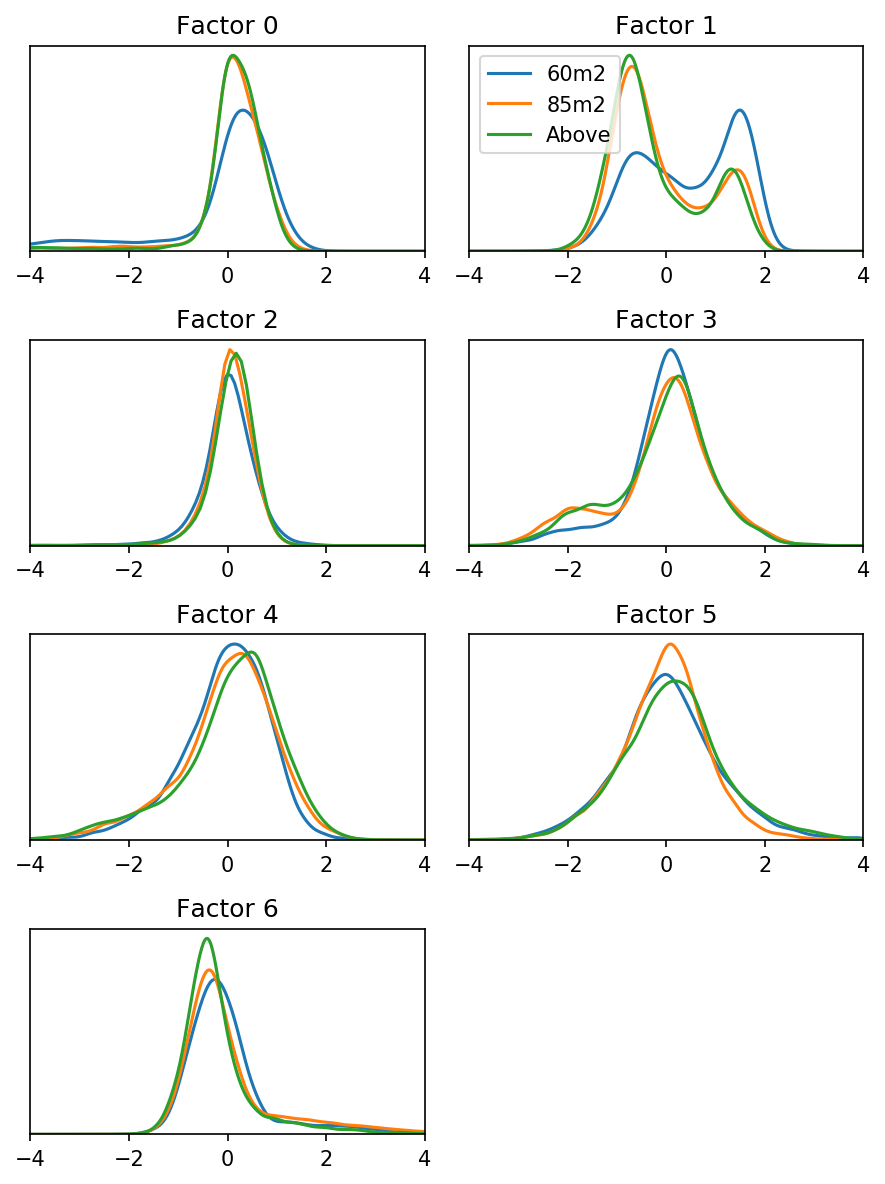

In [436]:
n_cols = 2
if len(col_factors) % cols:
    n_rows = len(col_factors)//n_cols + 1
else:
    n_rows = len(col_factors)//n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 8), dpi=150)
axes = axes.flatten()
[axes[i].set_axis_off() for i in range(len(col_factors), len(axes))]
    
for i, f in enumerate(col_factors):
    (df[f]
     .groupby(df['group_area'])
     .plot.kde(xlim=(-4, 4),
               ax=axes[i]))
    axes[i].set_ylim(bottom=0)
    axes[i].set_title('Factor {}'.format(i))

[axes[i].yaxis.set_visible(False) for i in range(len(axes))]
axes[n_cols-1].legend()
# plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.tight_layout()
plt.show()

In [549]:
# # pixel area from layers which ranges from 0 to 28*28=784

# df_pixel = pd.read_csv('/data/fp_pixel.csv')
# df_pixel = df_pixel.set_index('ID')
# display(df_pixel[:10])
# display(df_pixel.describe().T)

# col_pixels = df_pixel.columns

# df = df.drop(col_pixels, axis='columns', errors='ignore')
# df = df.join(df_pixel)
# display(df[:1].T)

In [548]:
### kde plots for pixel counts vs area groups

# col_for_plots = col_pixels
# n_cols = 2
# if len(col_for_plots) % cols:
#     n_rows = len(col_for_plots)//n_cols + 1
# else:
#     n_rows = len(col_for_plots)//n_cols

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 8), dpi=150)
# axes = axes.flatten()
# [axes[i].set_axis_off() for i in range(len(col_for_plots), len(axes))]
    
# for i, c in enumerate(col_for_plots):
#     (df[c]
#      .groupby(df['group_area'])
#      .plot.kde(ax=axes[i]))
#     axes[i].set_xlim(left=0, right=df[c].max())
#     axes[i].set_ylim(bottom=0)
#     axes[i].set_title(c)

# [axes[i].yaxis.set_visible(False) for i in range(len(axes))]
# axes[n_cols-1].legend()
# # plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.tight_layout()
# plt.show()

In [547]:
### factors over years hexbin plots by area groups

# # fig = plt.figure(figsize=(5, 4), dpi=150)
# col_groups = ['60m2', '85m2', 'Above']
# n_rows, n_cols = len(col_factors), len(col_groups)
# fig, axes = plt.subplots(n_rows, n_cols, 
#                          sharex=True, 
#                          sharey=True,
#                          figsize=(4, 8), dpi=600)

# for c, col in enumerate(col_groups):
#     axes[0][c].set_title(col)

# for r, row in enumerate(col_factors):
#     for c, col in enumerate(col_groups):
#         (df.loc[df['group_area']==col]
#          .plot.hexbin(ax=axes[r][c],
#                       x='year', y=row,
#                       extent=(1969, 2019, -3, 3), 
#                       xlim=(1969, 2019), 
#                       ylim=(-3, 3), 
#                       gridsize=(13,39),
#                       bins='log', 
#                       mincnt=10,
#                       colorbar=False))
#         axes[r][c].set_yticks([], minor=True)
#         axes[r][c].set_yticks([-2,0,2])
        
#         axes[r][c].set_xticks([1970, 2000])
#         axes[r][c].set_xticks([1970, 1980, 1990, 2000, 2010], minor=True)

# #         axes[r][c].xaxis.set_visible(False)



    
        
# # ax.set_facecolor('w')
# # ax.set_aspect('equal')
# # ax.text(0.02,0.98,r2_text, verticalalignment='top')

# # if predict_test_only: 
# #     dataset_tag = "_testonly"
# # else:
# #     dataset_tag = ""

# # fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".pdf")
# # fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".png")

In [383]:
# X = df[col_factors]
# r2s = []
# for attr in col_attributes:
#     Y = df[attr]
#     regr = LinearRegression().fit(X, Y)
#     r2s.append(regr.score(X, Y))
# #     print(regr.score(X, Y))

# # r2s
# fig = plt.figure(figsize=(6, 3), dpi=150)
# ax = fig.gca()
# plt.bar(col_attributes, r2s)
# plt.ylim(0, 1)

# texts = ax.get_xticklabels()
# [text.set_rotation(45) for text in texts]
# [text.set_ha('right') for text in texts]

# for i, v in enumerate(r2s):
#     if v < 0.95:
#         ax.text(i, v, '{:0.3f}'.format(v), ha='center', va='bottom')
#     else:
#         ax.text(i, v, '{:0.3f}'.format(v), color='w', ha='center', va='top')

# plt.show()

In [382]:
# corr = df.corr()

# fig = plt.figure(figsize=(6, 4), dpi=150)
# ax = plt.gca()
# im = ax.matshow(corr.loc[col_factors, col_attributes], cmap='coolwarm', norm=DivergingNorm(0))

# fig.colorbar(im)

# ax.set_ylabel('Factors')

# ax.set_xticks(range(len(col_attributes)))
# texts = ax.set_xticklabels(col_attributes)
# [text.set_rotation(45) for text in texts]
# [text.set_ha('left') for text in texts]

# for (r, c), value in np.ndenumerate(corr.loc[col_factors, col_attributes]):
#     if abs(value) > 0.5:
#         fontcolor = 'w'
#     else:
#         fontcolor = 'k'
#     ax.text(c, r, '{:0.2f}'.format(value), c=fontcolor, ha='center', va='center')

# plt.show()

In [550]:
BATCH_SIZE = 8

def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [551]:
predict_dataset =  create_predict_dataset(
    ["/data/fp_train.tfrecord",
     "/data/fp_test.tfrecord"])
iter = predict_dataset.make_one_shot_iterator()

fps = []
for batch in iter:
    fps.extend(batch[0].numpy())

len(fps), fps[0][:,:,0].shape

Instructions for updating:
Colocations handled automatically by placer.


(50540, (28, 28))

[[ 0.    0.    0.    1.  ]
 [-1.   -0.67 -1.    0.  ]
 [ 0.   -0.75 -1.    0.  ]
 [-1.   -0.74  0.    0.  ]
 [-0.17 -0.13 -1.    0.  ]
 [-1.   -0.19 -0.24  0.  ]]
(28, 28, 6)
(50540, 28, 28, 4)


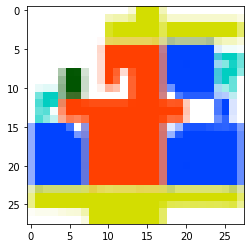

In [554]:
# adjusted for different luminance
channel_to_rgba = np.array(
    [[0., 0., 0., 1.], # unit mask to alpha
     [0., 0.33, 0., 0.], # entrance to green L30
     [1., 0.25, 0., 0.], # LDK to red L57
     [0., 0.26, 1., 0.], # bedroom to blue L40
     [0.83, 0.87, 0., 0.], # balcony to yellow L85
     [0., 0.81, 0.76, 0.]]) # bathroom to cyan L75

# make colors subtractive
channel_to_rgba[1:6, 0:3] -= 1

print(channel_to_rgba)
print(fps[0].shape)

# put it on transparent white
fps_rgba = np.array([1.,1.,1.,0.])+(np.array(fps) @ channel_to_rgba)
print(fps_rgba.shape)

np.set_printoptions(suppress=True)
# print(np.amin(fps_rgba, axis=(1,2,3)))
# print(np.amax(fps_rgba, axis=(1,2,3)))
fps_rgba = np.clip(fps_rgba, 0, 1)

fig = plt.figure()
ax = plt.imshow(fps_rgba[5])

In [556]:
df['weight'] = df.N_Units.clip(1, ) # at least 1 unit exists

n_factors = len(col_factors)

sigma = [[-5, 5]] * n_factors

n_bins, n_samples = 40, 10
N = n_bins * n_samples

for f, factor in enumerate(col_factors):
    bin_f = 'bin{}'.format(f)
    df[bin_f] = pd.cut(df[factor].clip(*sigma[f]), n_bins, labels=False)

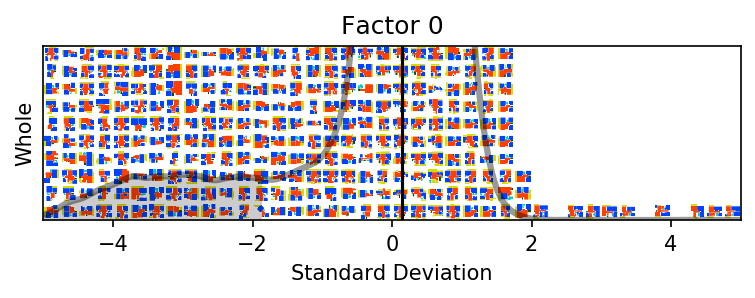

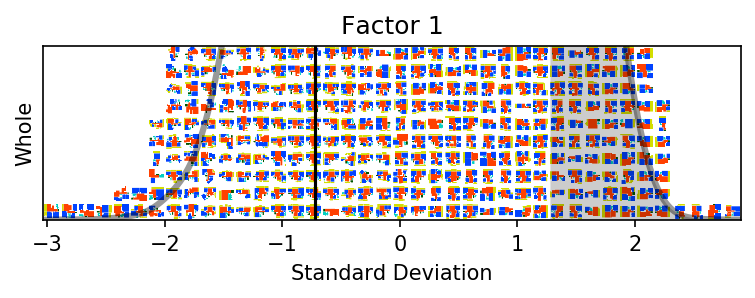

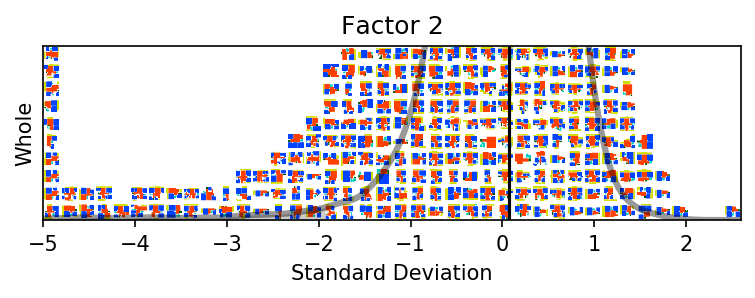

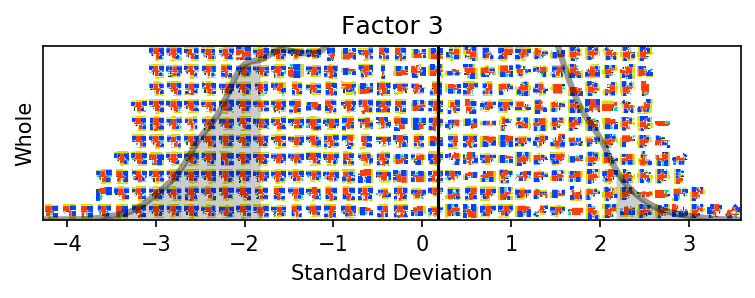

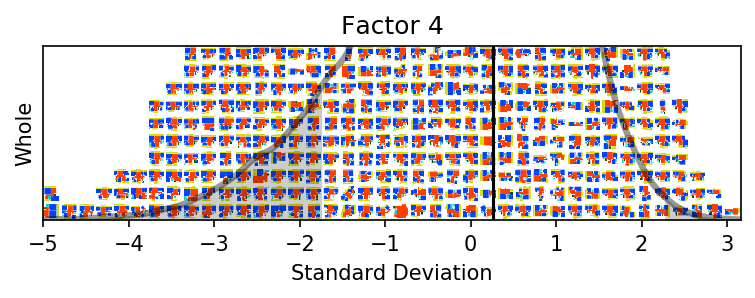

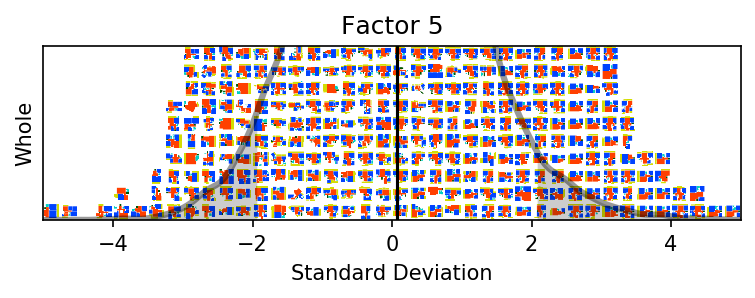

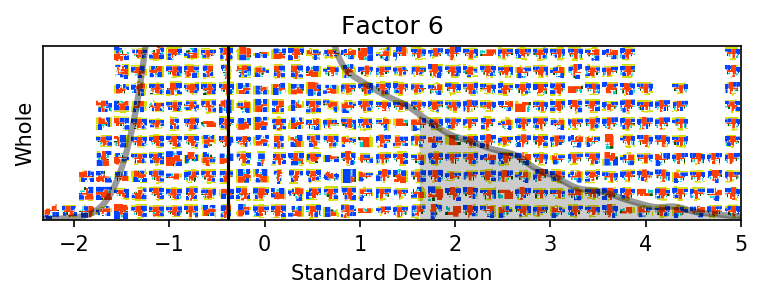

In [564]:
# stratified sample by standard deviation

border = 2
interval = 28 + border*2

fp_map = np.zeros((n_factors, n_samples*interval, n_bins*interval, 4)) # rc coord

# sample = df.sample(N, weights='weight', random_state=1106)

for f, factor in enumerate(col_factors):
    bin_f = 'bin{}'.format(f)
    
    for c in range(n_bins):
        df_bin = df[df[bin_f] == c]
        
        if len(df_bin):
            sample = df_bin.sample(min(len(df_bin)//10 + 1, n_samples), weights='weight', random_state=1106)
            rows = sample.sort_values(by=factor).row

            for r in range(len(rows)):
                row = rows.iat[r]
                fp_map[f, 
                       r*interval+border:(r+1)*interval-border, 
                       c*interval+border:(c+1)*interval-border, 
                       :] = fps_rgba[row]

# fig, axs = plt.subplots(n_factors, 1, figsize=(36, 36))
for f, factor in enumerate(col_factors):
    fig = plt.figure(figsize=(6, 12), dpi=150)

    df_clipped = df[factor].clip(*sigma[f])
    xlim = [df_clipped.min(), df_clipped.max()]
    
    ax = fig.gca()
    
    kernel = gaussian_kde(df[factor])
    xs = np.arange(*xlim, (xlim[1]-xlim[0])/1000)
    ys = kernel(xs)
    ax.plot(xs, ys, color='k', linewidth=3, alpha=0.4)

    x_mode = xs[np.argmax(ys)]
    line_mode = ax.vlines(x_mode, 0, ys.max(), color='k')
    
    x_left_tail, x_right_tail = xs.searchsorted(x_mode-2), xs.searchsorted(x_mode+2)
    xs_left, xs_right = xs[0:x_left_tail], xs[x_right_tail:-1]
    ys_left, ys_right = ys[0:x_left_tail], ys[x_right_tail:-1]

    poly_tail = ax.fill_between(xs_left, ys_left, color='k', linewidth=0, alpha=0.2)
    ax.fill_between(xs_right, ys_right, color='k', linewidth=0, alpha=0.2)
    
#     ymax = ys.mean()
#     ymax = np.median(ys)
#     ymax = 1 / (xlim[1]-xlim[0])
    ymax = 0.1
#     ymax = max([a.max() for a in [ys_left, ys_right] if a.any()]) *2
    ax.imshow(fp_map[f], aspect=((xlim[1]-xlim[0])/ymax)/(n_bins/n_samples), 
              origin='lower', extent=[*xlim, 0., ymax], zorder=0)

#     is_right_tail = x_mode <= 0 # True if positive skew
#     loc_legend = 2 if is_right_tail else 1 # upper left if right tail and vice versa
#     ax.legend((line_mode, poly_tail), ('Mode', '>2std from mode'), loc=loc_legend)

    ax.set_title('Factor {}'.format(f))
    ax.set_yticks([])
    ax.set_ylabel('Whole')
#     ax.set_ylim((0, ymax))
    
#     ax.set_xticks(list(ax.get_xticks())+[x_mode])
#     ax.set_xlim(xlim)

    ax.set_xlabel('Standard Deviation')
    
    plt.show()


In [ ]:
# stratified sample by standard deviation for area groups TBD

border = 2
interval = 28 + border*2

fp_map = np.zeros((n_factors, n_samples*interval, n_bins*interval, 4)) # rc coord

# sample = df.sample(N, weights='weight', random_state=1106)

for f, factor in enumerate(col_factors):
    bin_f = 'bin{}'.format(f)
    
    for c in range(n_bins):
        df_bin = df[df[bin_f] == c]
        
        if len(df_bin):
            sample = df_bin.sample(min(len(df_bin)//10 + 1, n_samples), weights='weight', random_state=1106)
            rows = sample.sort_values(by=factor).row

            for r in range(len(rows)):
                row = rows.iat[r]
                fp_map[f, 
                       r*interval+border:(r+1)*interval-border, 
                       c*interval+border:(c+1)*interval-border, 
                       :] = fps_rgba[row]

# fig, axs = plt.subplots(n_factors, 1, figsize=(36, 36))
for f, factor in enumerate(col_factors):
    fig = plt.figure(figsize=(6, 12), dpi=150)

    df_clipped = df[factor].clip(*sigma[f])
    xlim = [df_clipped.min(), df_clipped.max()]
    
    ax = fig.gca()
    
    kernel = gaussian_kde(df[factor])
    xs = np.arange(*xlim, (xlim[1]-xlim[0])/1000)
    ys = kernel(xs)
    ax.plot(xs, ys, color='k', linewidth=3, alpha=0.4)

    x_mode = xs[np.argmax(ys)]
    line_mode = ax.vlines(x_mode, 0, ys.max(), color='k')
    
    x_left_tail, x_right_tail = xs.searchsorted(x_mode-2), xs.searchsorted(x_mode+2)
    xs_left, xs_right = xs[0:x_left_tail], xs[x_right_tail:-1]
    ys_left, ys_right = ys[0:x_left_tail], ys[x_right_tail:-1]

    poly_tail = ax.fill_between(xs_left, ys_left, color='k', linewidth=0, alpha=0.2)
    ax.fill_between(xs_right, ys_right, color='k', linewidth=0, alpha=0.2)
    
#     ymax = ys.mean()
#     ymax = np.median(ys)
#     ymax = 1 / (xlim[1]-xlim[0])
    ymax = 0.1
#     ymax = max([a.max() for a in [ys_left, ys_right] if a.any()]) *2
    ax.imshow(fp_map[f], aspect=((xlim[1]-xlim[0])/ymax)/(n_bins/n_samples), 
              origin='lower', extent=[*xlim, 0., ymax], zorder=0)

#     is_right_tail = x_mode <= 0 # True if positive skew
#     loc_legend = 2 if is_right_tail else 1 # upper left if right tail and vice versa
#     ax.legend((line_mode, poly_tail), ('Mode', '>2std from mode'), loc=loc_legend)

    ax.set_title('Factor {}'.format(f))
    ax.set_yticks([])
    ax.set_ylabel('Whole')
#     ax.set_ylim((0, ymax))
    
#     ax.set_xticks(list(ax.get_xticks())+[x_mode])
#     ax.set_xlim(xlim)

    ax.set_xlabel('Standard Deviation')
    
    plt.show()


In [ ]:
# 2D stratified sample by two factors

border = 2
interval = 28 + border*2

fp_map2d = np.zeros((n_factors, n_factors, n_bins*interval, n_bins*interval, 4)) # rc coord

for fc, fr in combinations(range(n_factors), 2):
    bin_fc, bin_fr = ['bin{}'.format(f) for f in [fc, fr]]
    
    for c in range(n_bins):
        for r in range(n_bins):
            df_bin = df[(df[bin_fc] == c) & (df[bin_fr] == r)]
        
            if len(df_bin)>=2: # expects 2*2500/50000 = 1/10 likelihood
                sample = df_bin.sample(1, weights='weight', random_state=1106)
                row = sample.row.iat[0]
                
                fp_map2d[fc, fr,
                         r*interval+border:(r+1)*interval-border, 
                         c*interval+border:(c+1)*interval-border, 
                         :] = fps_rgba[row]

# fig, axs = plt.subplots(n_factors, 1, figsize=(36, 36))
for fc, fr in combinations(range(n_factors), 2):

    df_clipped_x, df_clipped_y = [df['factor{}'.format(f)].clip(*sigma[f]) 
                                  for f in [fc, fr]]
    xlim, ylim = [[df_clipped.min(), df_clipped.max()]
                  for df_clipped in [df_clipped_x, df_clipped_y]]
    
    fig = plt.figure(figsize=(12, 12), dpi=150)
    ax = fig.gca()
    
#     kernel = gaussian_kde(df['factor{}'.format(f)])
#     xs = np.arange(*xlim, (xlim[1]-xlim[0])/1000)
#     ys = kernel(xs)
#     ax.plot(xs, ys, color='k', linewidth=3, alpha=0.4)

#     x_mode = xs[np.argmax(ys)]
#     line_mode = ax.vlines(x_mode, 0, ys.max(), color='k')
    
#     x_left_tail, x_right_tail = xs.searchsorted(x_mode-2), xs.searchsorted(x_mode+2)
#     xs_left, xs_right = xs[0:x_left_tail], xs[x_right_tail:-1]
#     ys_left, ys_right = ys[0:x_left_tail], ys[x_right_tail:-1]

#     poly_tail = ax.fill_between(xs_left, ys_left, color='k', linewidth=0, alpha=0.2)
#     ax.fill_between(xs_right, ys_right, color='k', linewidth=0, alpha=0.2)
    
    ax.imshow(fp_map2d[fc, fr], aspect=((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))/(n_bins/n_bins), 
              origin='lower', extent=[*xlim, *ylim], zorder=0)

#     is_right_tail = x_mode <= 0 # True if positive skew
#     loc_legend = 2 if is_right_tail else 1 # upper left if right tail and vice versa
#     ax.legend((line_mode, poly_tail), ('Mode', '>2std from mode'), loc=loc_legend)

    ax.set_title('Factor {} - Factor {}'.format(fc, fr))
    ax.set_xlabel('Factor {}'.format(fc))
    ax.set_ylabel('Factor {}'.format(fr))

#     ax.set_xlim(xlim)
   
    plt.show()